---
# <div align="left"> <font color='green'> COSC 2673/2793 | Machine Learning</font></div>
### <div align="left"> <font color='green'> Assignment 1: Introduction to Machine Learning</font></div>
### <div align="left"> <font color='blue'> Student Name: Shekhar Hazari</font></div>
### <div align="left"> <font color='blue'> Student ID: S3831855</font></div>
---

## Introduction to problem
- How does an individual choose what hospital to go to if they have a condition which requires the individual to be admitted in for care? The natural answer comes down to how efficient a hospital is. One such measure of efficiency is Average Length of stay.The average length of stay in hospitals (ALOS) is often used as an indicator of efficiency. All other things being equal, a shorter stay will reduce the cost per discharge and shift care from inpatient to less expensive post acute settings. The ALOS refers to the average number of days that patients spend in hospital. It is generally measured by dividing the total number of days stayed by all inpatients during a year by the number of admissions or discharges. Day cases are excluded. The indicator is presented both for all acute care cases and for childbirth without complications.
- With this in mind, our task in this assignment will be to distinguish the when a longer stay will be required than an acute care case. If a patient is admitted for less than 4 days, it is termed as an acute care case. A longer stay in hospital will be classified as 1, on the other hand an acute care case will be classified as 0.

In [1]:
# Importing required libraries and
!pip install graphviz
import numpy as np
import pandas as pd
pd.set_option("display.precision", 3)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# Reading the data from CSV
# Ignoring column 'HealthServiceArea' (as indicated in the Assignment specification) and setting the ID as index column
# so that none of these columns are used as training attributes.
data = pd.read_csv('train_data.csv', index_col = 'ID', usecols = ['ID', 'Gender', 'Race', 'TypeOfAdmission', 'CCSProcedureCode',
                                                                  'APRSeverityOfIllnessCode', 'PaymentTypology', 'BirthWeight',
                                                                 'EmergencyDepartmentIndicator', 'AverageCostInCounty',
                                                                  'AverageChargesInCounty', 'AverageCostInFacility',
                                                                  'AverageChargesInFacility', 'AverageIncomeInZipCode', 'LengthOfStay'])

In [3]:
# Looking at the first few rows of the data
data.head()

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
ID,,,,,,,,,,,,,,
1,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1
2,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,1
3,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,1
4,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,1
5,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,1


In [4]:
# Checking the size of the dataset, if there are null values and the data types of various columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 1 to 59966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Gender                        59966 non-null  object
 1   Race                          59966 non-null  object
 2   TypeOfAdmission               59966 non-null  object
 3   CCSProcedureCode              59966 non-null  int64 
 4   APRSeverityOfIllnessCode      59966 non-null  int64 
 5   PaymentTypology               59966 non-null  object
 6   BirthWeight                   59966 non-null  int64 
 7   EmergencyDepartmentIndicator  59966 non-null  object
 8   AverageCostInCounty           59966 non-null  int64 
 9   AverageChargesInCounty        59966 non-null  int64 
 10  AverageCostInFacility         59966 non-null  int64 
 11  AverageChargesInFacility      59966 non-null  int64 
 12  AverageIncomeInZipCode        59966 non-null  int64 
 13  LengthOfStay    

## Reading the data
- While reading the data, the column *HealthServiceArea* was ignored and column 'ID' was used as index (this won't be used in model training).
- Printing the first few rows of the data shows the import was successful and as expected.
- We can see that the data has 59966 rows (number of patients) and 14 columns.
- All these columns are not in the desired type for example *CCSProcedureCode* has been imported as an int data type where it's a category of procedure used. These type conversions will be done in next section

In [5]:
# Converting columns to correct datatypes based on attribute definitions in assignment specifications
cat_col = ['Gender', 'Race', 'TypeOfAdmission', 'CCSProcedureCode',
           'PaymentTypology', 'EmergencyDepartmentIndicator']
num_col = ['AverageCostInCounty','AverageChargesInCounty', 'AverageCostInFacility',
           'AverageChargesInFacility', 'AverageIncomeInZipCode', 'BirthWeight']
data.loc[data.LengthOfStay < 4, "LengthOfStay"] = 0
data.loc[data.LengthOfStay > 3, "LengthOfStay"] = 1
for column_name in cat_col:
    data[column_name] = data[column_name].astype('category')

In [6]:
# Displaying the data information again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 1 to 59966
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Gender                        59966 non-null  category
 1   Race                          59966 non-null  category
 2   TypeOfAdmission               59966 non-null  category
 3   CCSProcedureCode              59966 non-null  category
 4   APRSeverityOfIllnessCode      59966 non-null  int64   
 5   PaymentTypology               59966 non-null  category
 6   BirthWeight                   59966 non-null  int64   
 7   EmergencyDepartmentIndicator  59966 non-null  category
 8   AverageCostInCounty           59966 non-null  int64   
 9   AverageChargesInCounty        59966 non-null  int64   
 10  AverageCostInFacility         59966 non-null  int64   
 11  AverageChargesInFacility      59966 non-null  int64   
 12  AverageIncomeInZipCode        59966 non-null  

#### All the data types have been successfully converted and we can begin our exploratory data analysis
## First Glance at the data:
There are approximately 60K observations in the dataset with a total of 13 attributes for model training and 1 target variable.

There are apparently no *NULL* values which is a good sign.

The attributes are a good mix of boolean, categorical, ordinal and numeric type.

In [7]:
data.head()

,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
ID,,,,,,,,,,,,,,
1,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,0
2,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,0
3,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,0
4,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,0
5,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,0


In [8]:
# Printing exploratory stats for all numeric columns in the dataset
data.describe()

,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
count,59966.000,59966.000,59966.000,59966.000,59966.000,59966.000,59966.000,59966.000
mean,1.255,3336.299,2372.807,7979.127,2396.414,7958.473,59.811,0.168
std,0.546,446.244,639.755,3220.291,1248.501,3859.295,21.470,0.374
min,1.000,2500.000,712.000,1243.000,457.000,1120.000,28.000,0.000
25%,1.000,3000.000,2041.000,4620.000,1551.000,4438.000,45.000,0.000
50%,1.000,3300.000,2533.000,9227.000,1967.000,7945.000,55.000,0.000
75%,1.000,3600.000,2785.000,10644.000,2895.000,11619.000,74.000,0.000
max,4.000,7500.000,3242.000,11381.000,8114.000,18466.000,115.000,1.000


#### Initial impressions
*BirthWeight* seems close to normal at first glance as mean and median values are fairly close. But a similar inference can not be made for other variables. Will explore this in more detail in later sections.

In [9]:
# Printing exploratory stats for non-numeric columns in the datset
data.describe(include=['category'])

,Gender,Race,TypeOfAdmission,CCSProcedureCode,PaymentTypology,EmergencyDepartmentIndicator
count,59966,59966,59966,59966,59966,59966
unique,3,4,4,7,9,2
top,M,White,Newborn,228,Medicaid,N
freq,30978,32943,58741,19886,28723,59453


##### Gender
Has a total of 3 unique values Male being the most frequent. Need to explore the frequency of other two categories.
##### Race
Has a total of 4 unique values White being the most frequent, which can be expected as the dataset is from the USA. Need to explore the frequency of other three categories.
##### TypeOfAdmission
Has a total of 4 unique values Newborn being the most frequent, and it seems almost all cases fall into this category (58741 of 59966). Need to explore the frequency of other three categories.
##### CCSProcedureCode
Has a total of 7 unique values 228 being the most frequent.
##### APRSeverityOfIllnessCode
Has a total of 4 unique values '1' being the most frequent.
##### PaymentTypology
Has a total of 9 unique values 'Medicaid' being the highest.
##### EmergencyDepartmentIndicator
Has a total of 2 unique values '0' being the most frequent, almost all cases fall in this category. That is expected given that there are lesser emergency cases. What would be interesting is to see break-up of these values by *LengthOfStay*

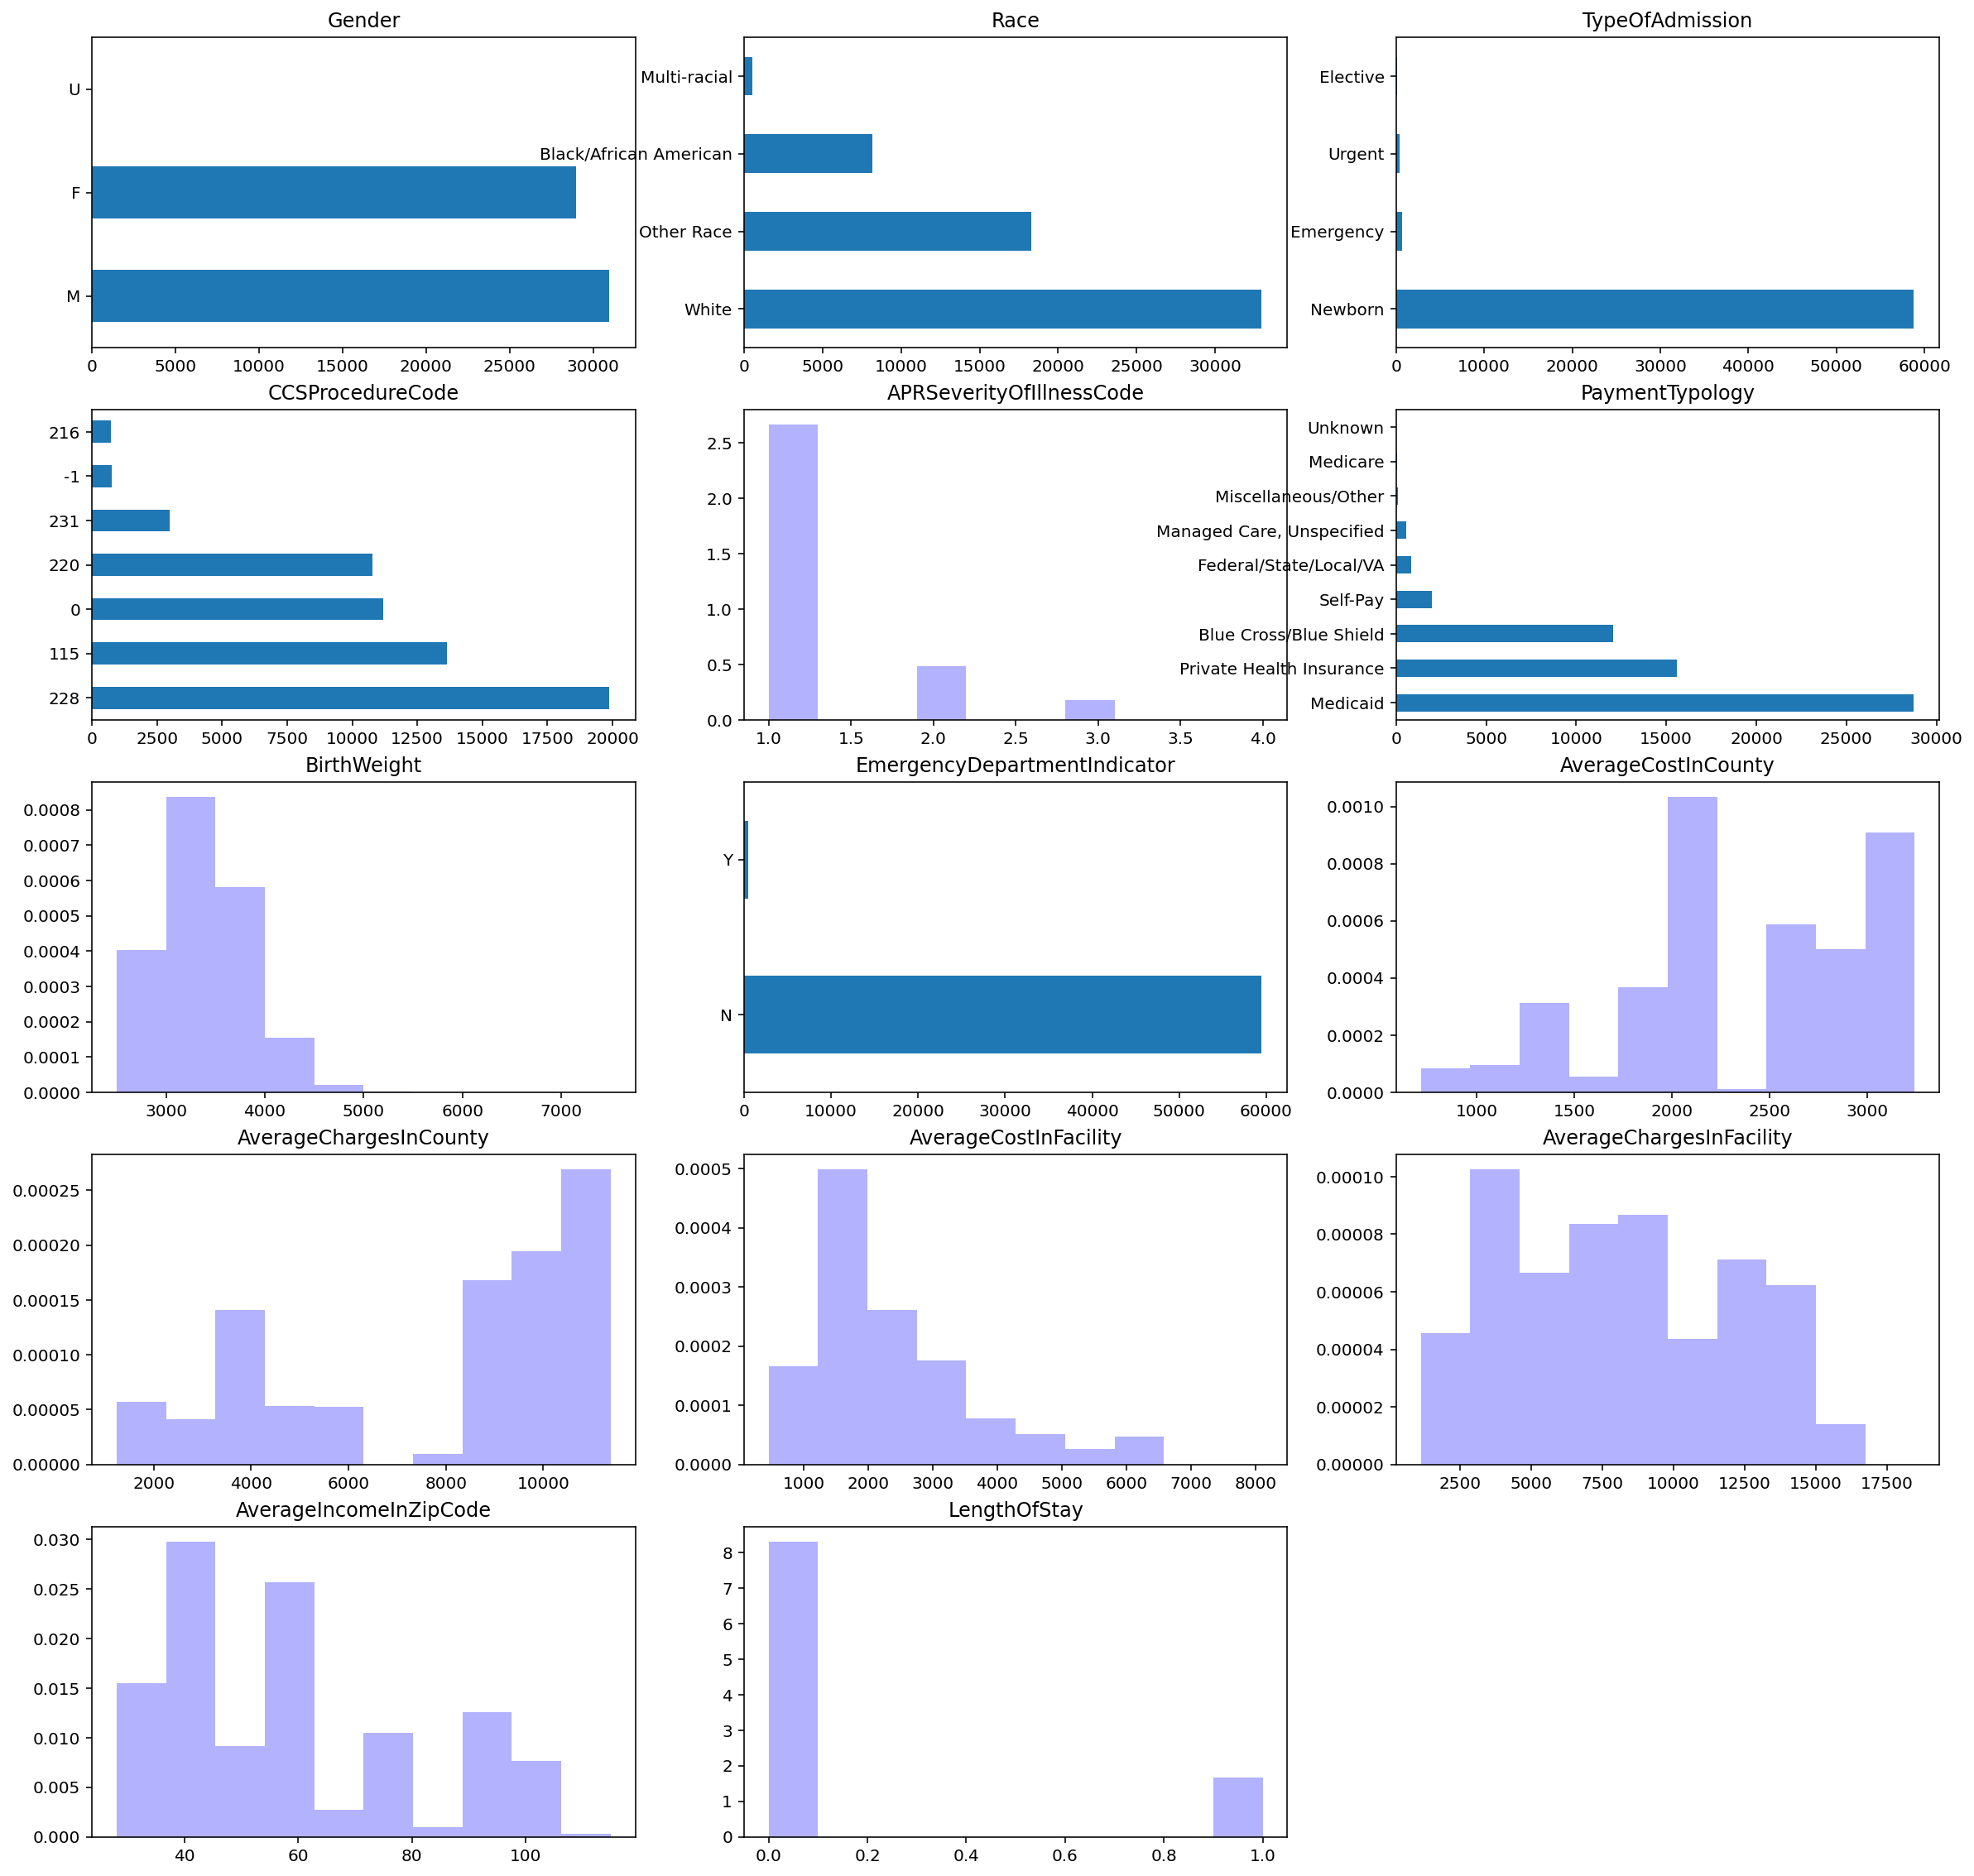

In [10]:
plt.figure(figsize=(20,20))
for i, column in enumerate(data.columns):
    plt.subplot(5,3,i+1)
    if is_numeric_dtype(data[column]):
        plt.hist(data[column], alpha=0.3, color='b', density=True)
        plt.title(column)
    else:
        data[column].value_counts().plot.barh()
        plt.title(column)

## Frequencies
#### Gender:
There seems to be no or very little examples for *unknown* category.
#### APRSeverityOfIllness:
There seems to be no or very little examples for *4* category.
#### PaymentTypology:
There seems to be no or very little examples for *unknown, medicare and miscellenious/other* categories.
## Distributions:
#### BirthWeight, AverageCostInFacility and AverageChargesInFacility:
Seems fairly normally distributed. Further investigation in distributions of numerical variables is required
##### LengthOfStay
Has a total of 2 unique values '0' being the most frequent, which means most cases are acute care level. But quite clearly there will be a problem of class imbalance while training the ML model.

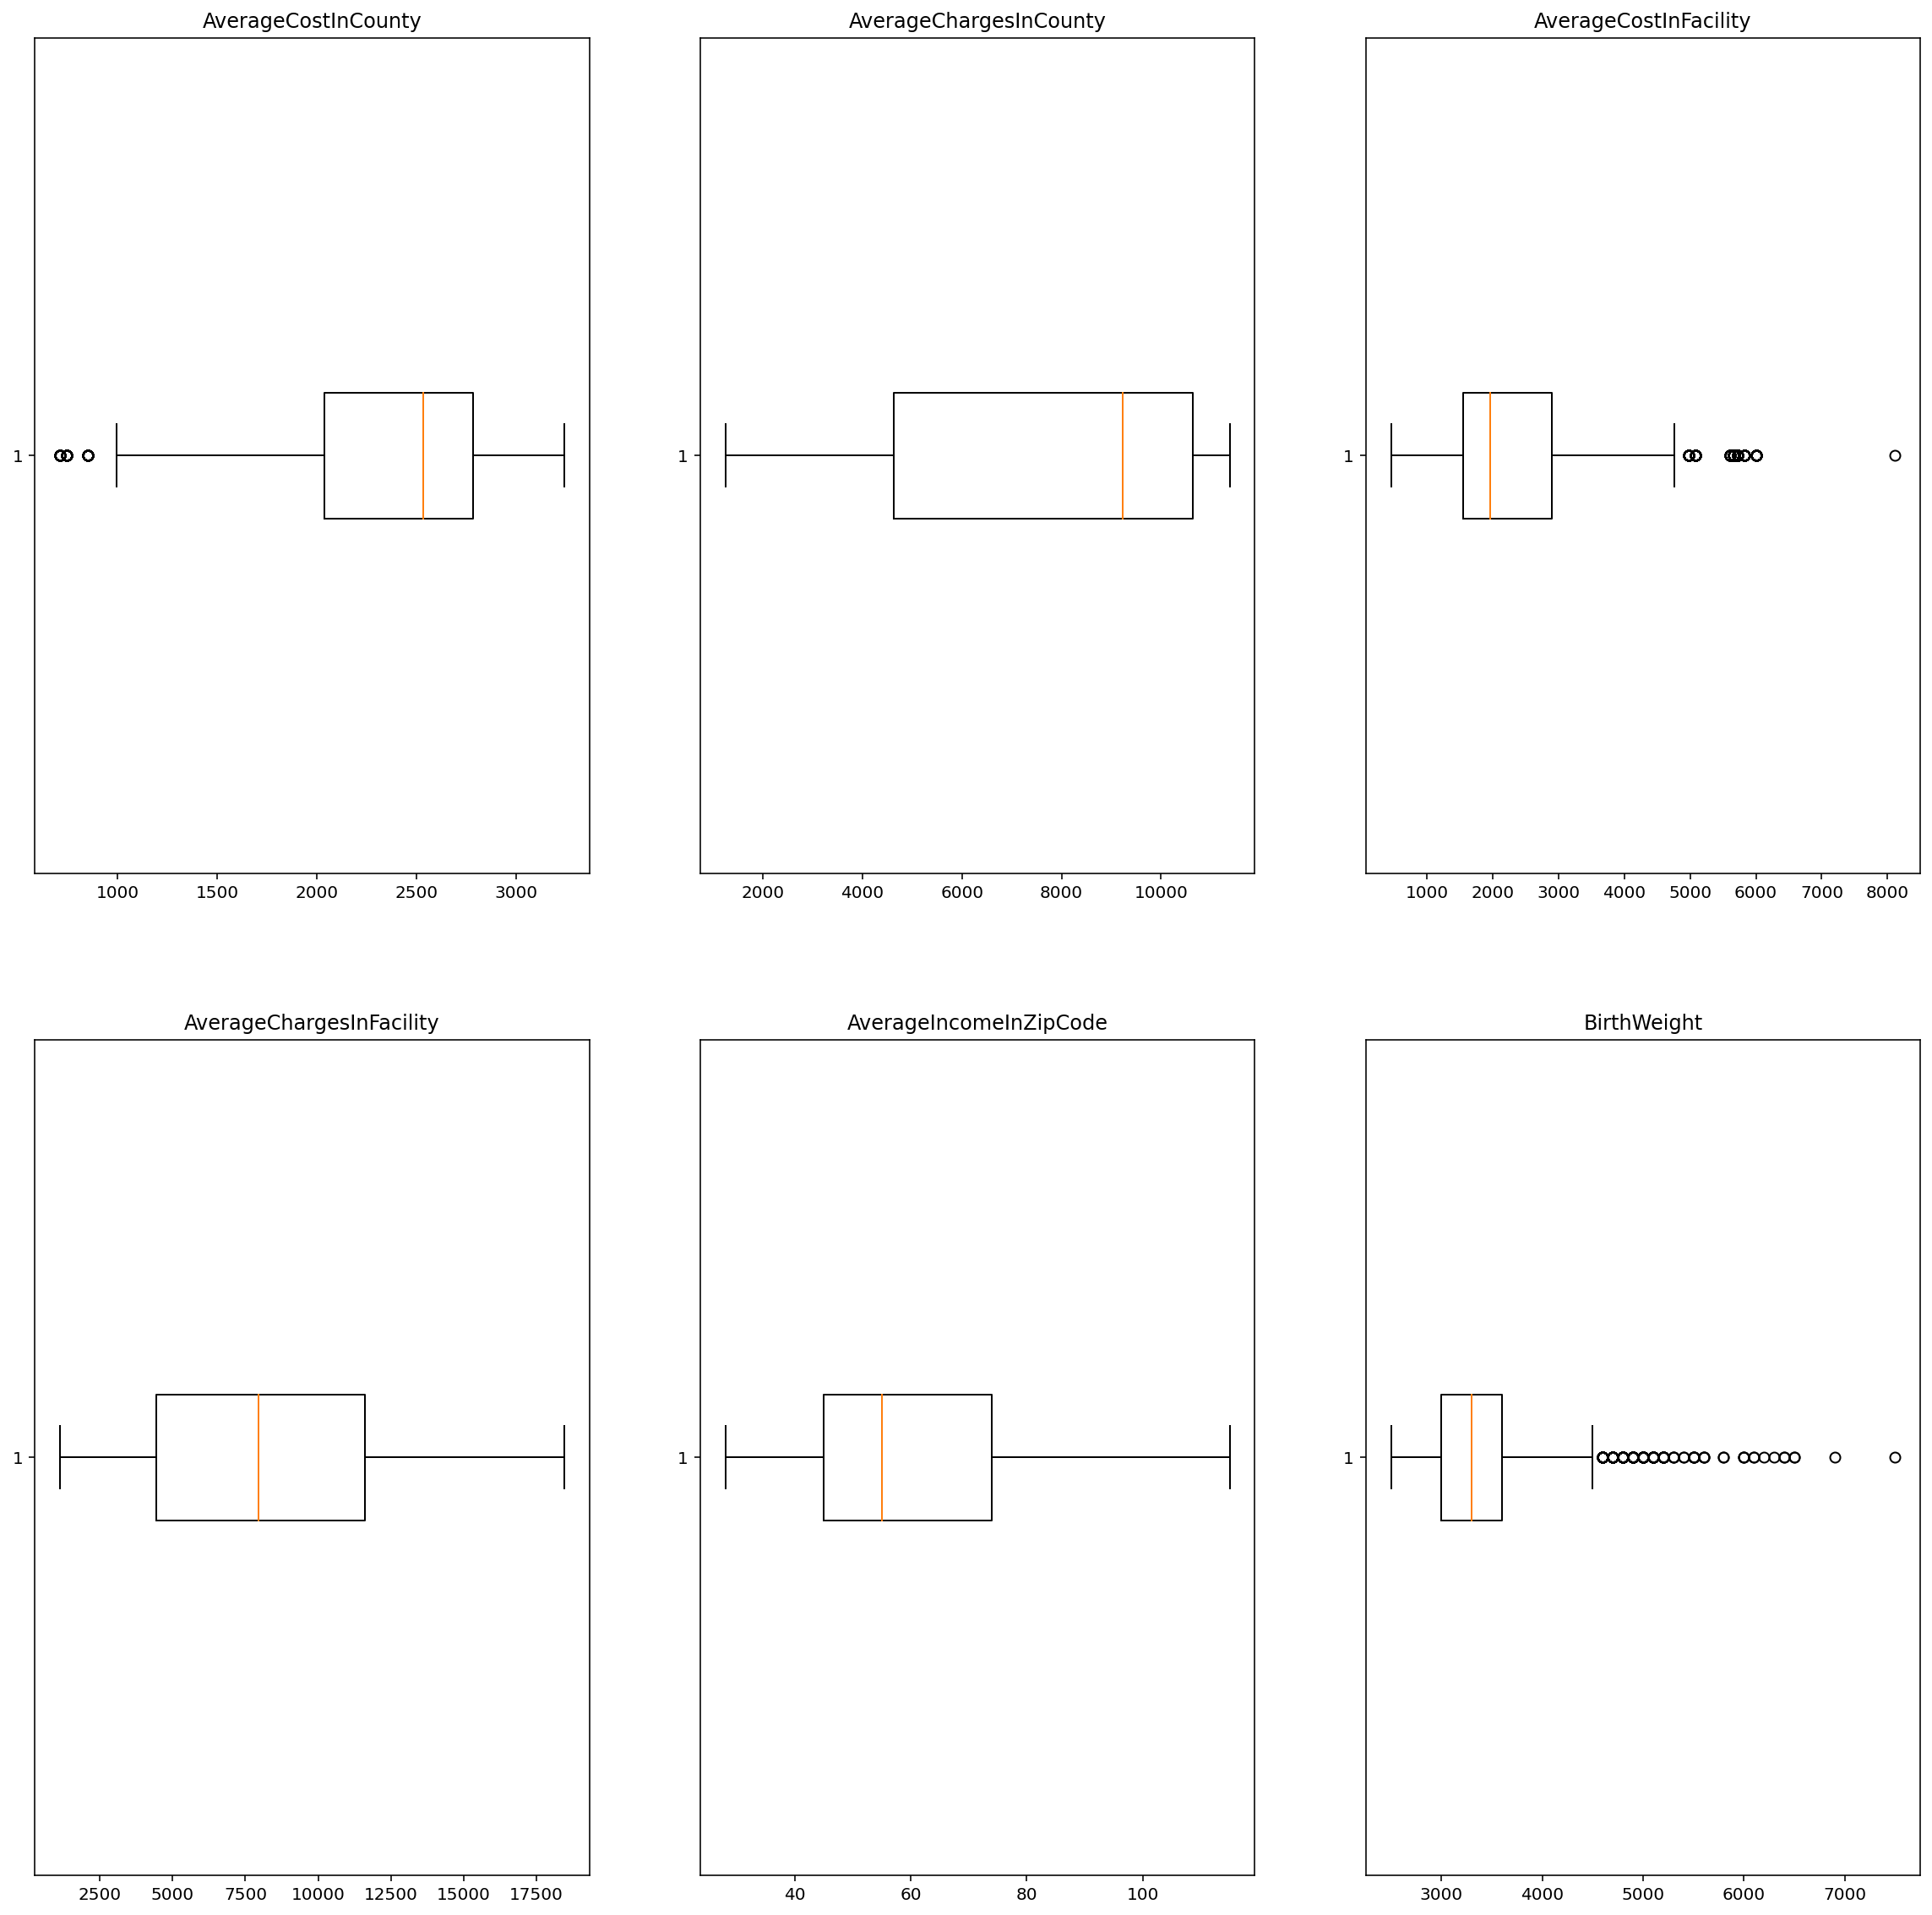

In [11]:
plt.figure(figsize=(20,20))
i = 1
for column in num_col:
    if is_numeric_dtype(data[column]):
        plt.subplot(2,3,i)
        i = i+1
        plt.boxplot(data[column], vert=False)
        plt.title(column)

### Observation:
- *Birthweight, AverageCostInCounty* and *AverageCostInFacility* seem to have some outliers. Will need to take this into account while transforming the data.
- Other attributes do not seem to be normally distributed as well, all have some degree of skewness in them and this will also be addressed while transforming these columns.

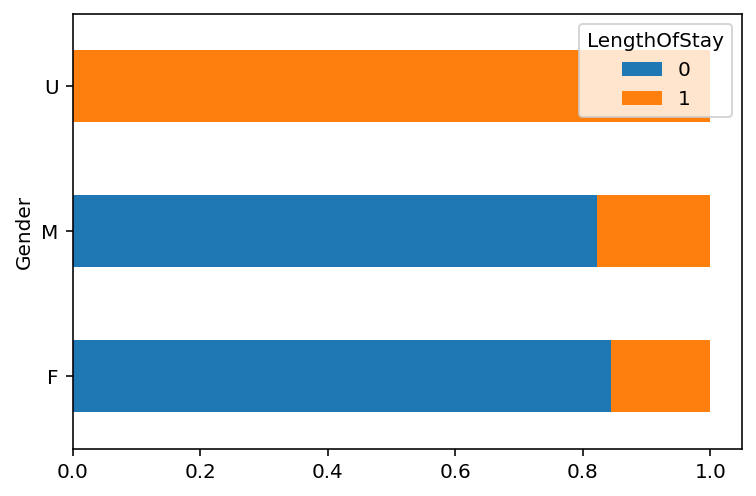

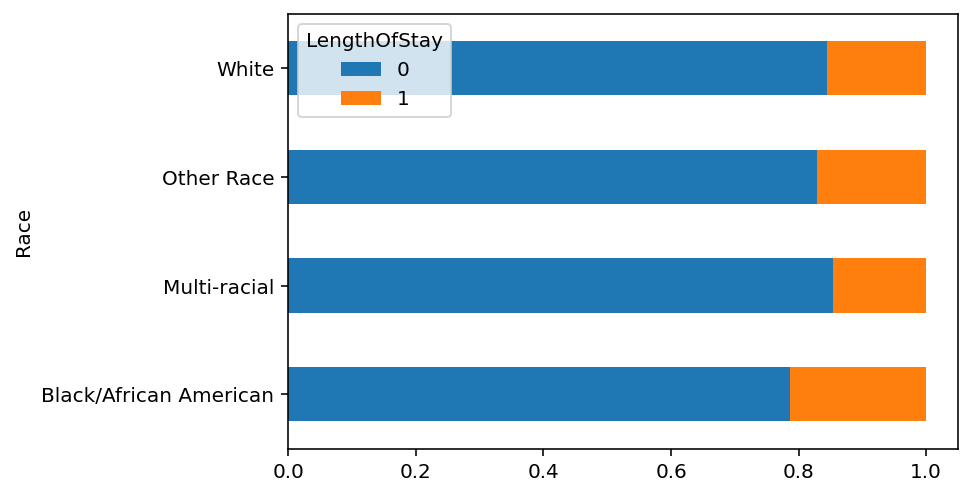

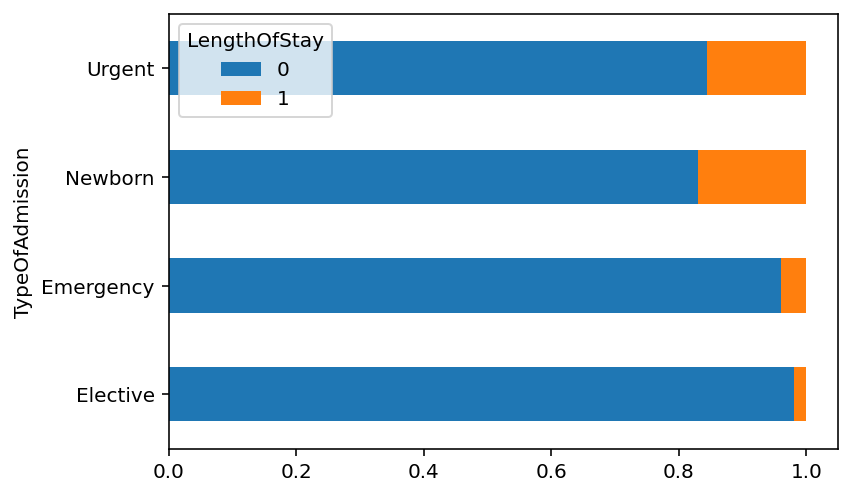

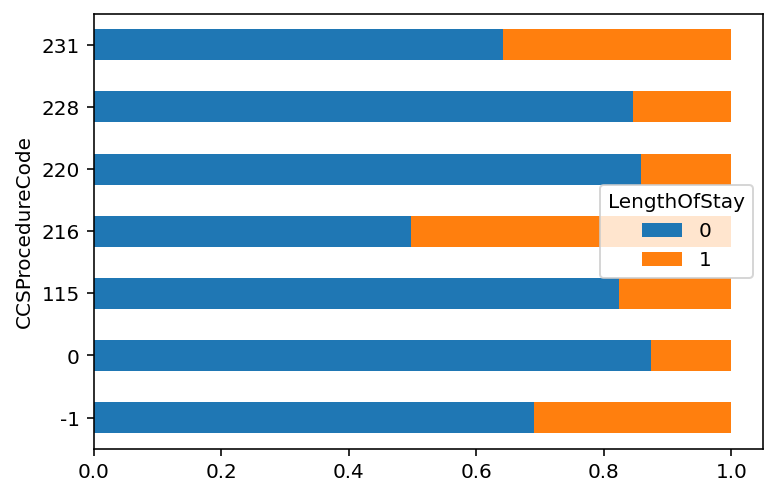

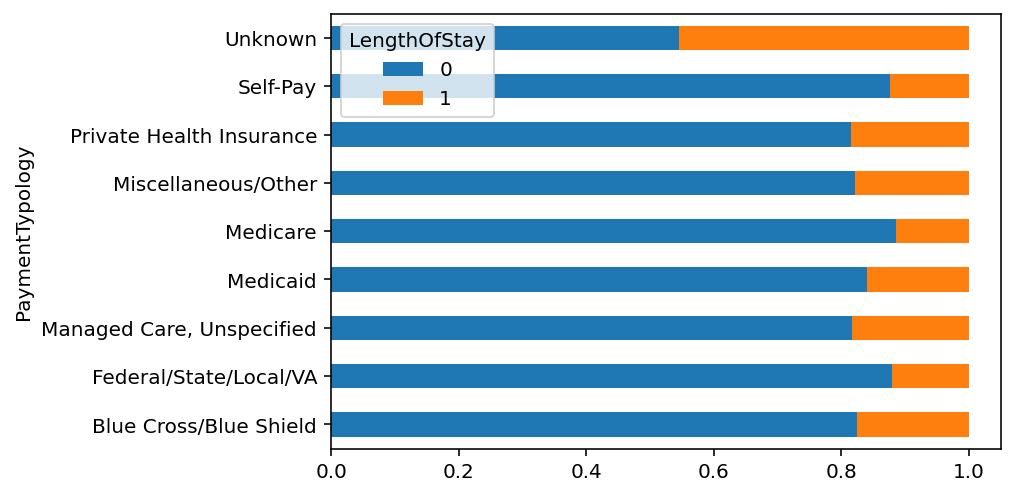

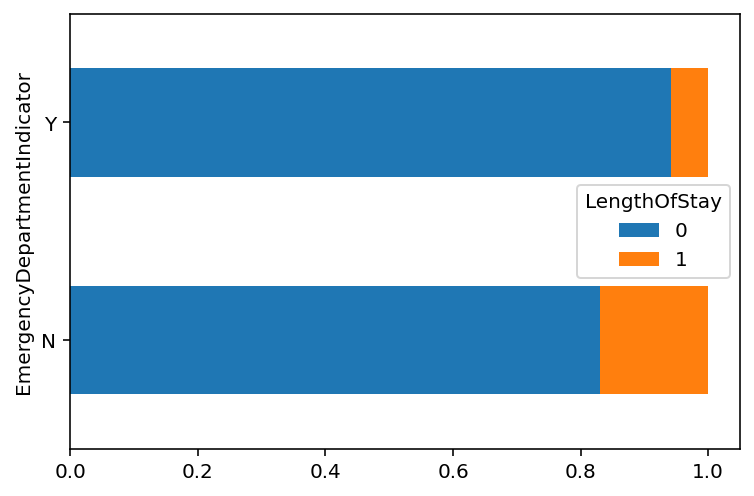

In [12]:
for column in data.columns:
    if not(is_numeric_dtype(data[column])):
        pd.crosstab(data[column], data['LengthOfStay'], margins = False, normalize='index').plot.barh(stacked = True)

### Observations:
- Higher *APRSeverityOfIllnessCode* is more likely to extend the stay of the patient.
- Patients who have *CCSProcedureCode* -1, 216 or 231 are more likely to stay beyond acute care length.

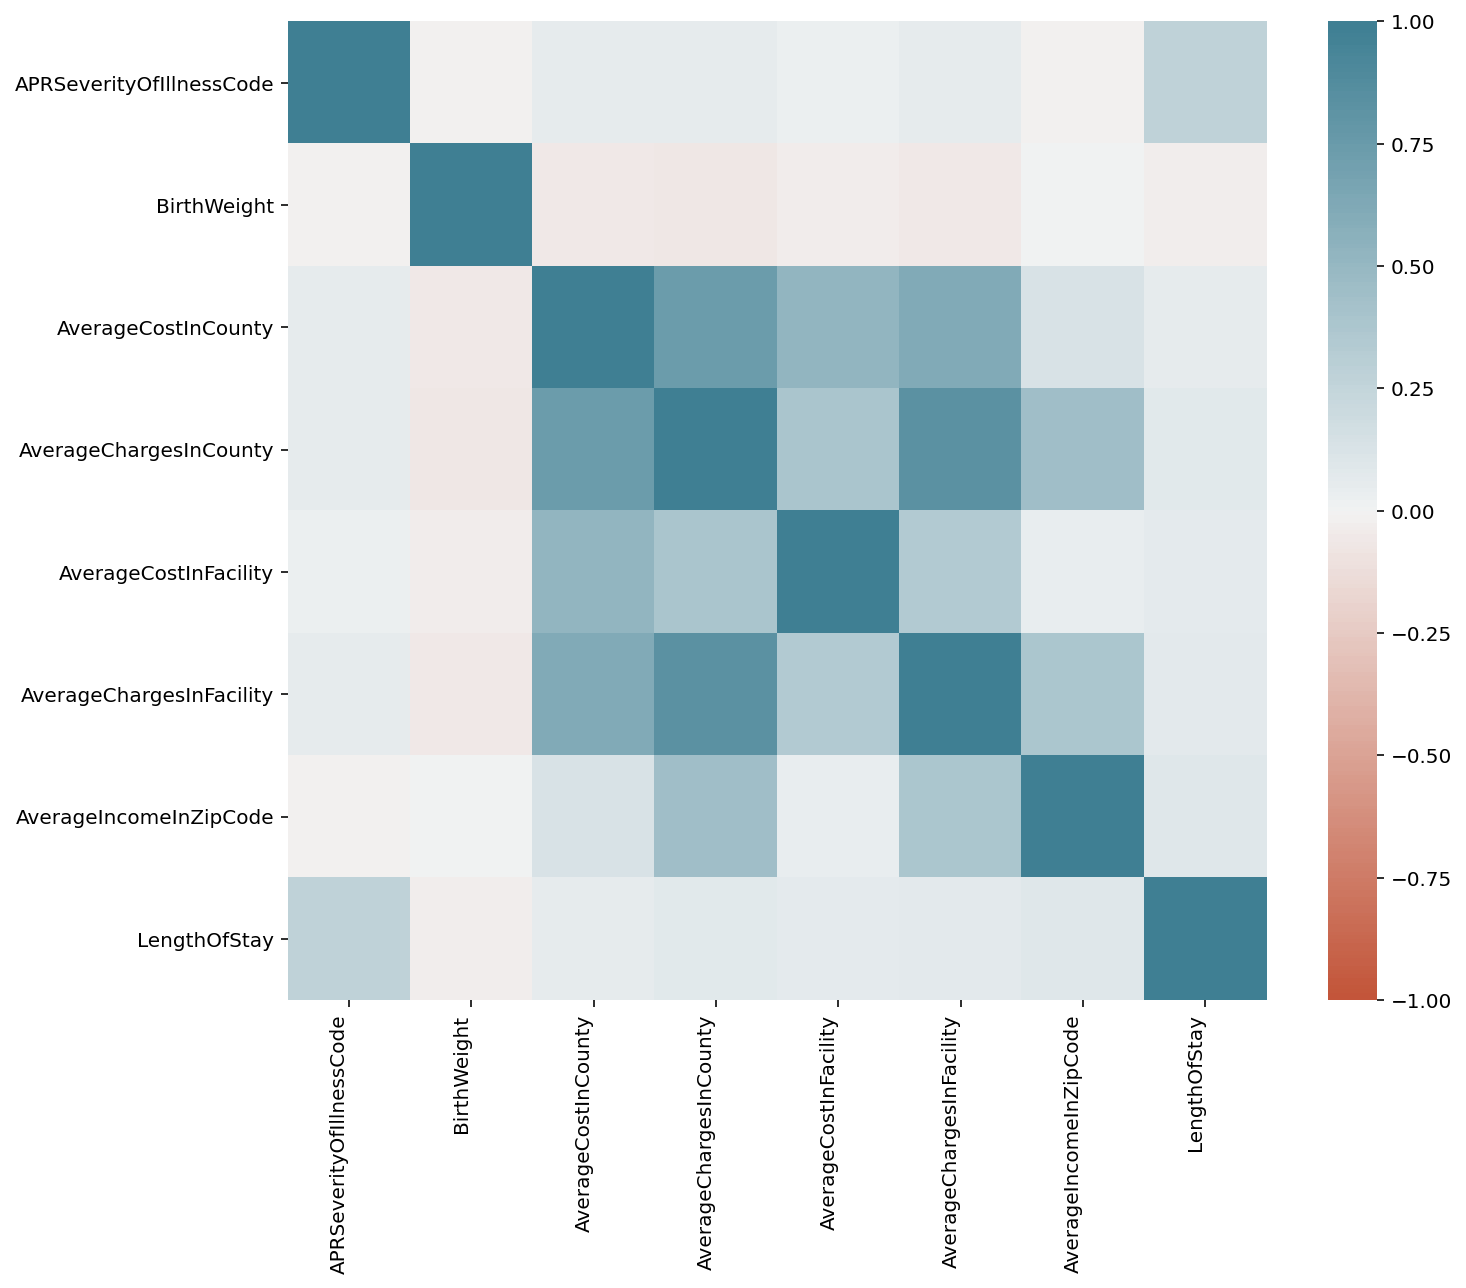

In [13]:
f, ax = plt.subplots(figsize=(11, 9))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

### From Correlation plot:
- There are a few variables which are colrrelated within themselves. For example *AverageCostInCounty and AverageChargesInCounty* seem fairly correlated around the 0.5 mark but not correlated enough (more than 0.7) to remove one of these variables for the purpose of model training.

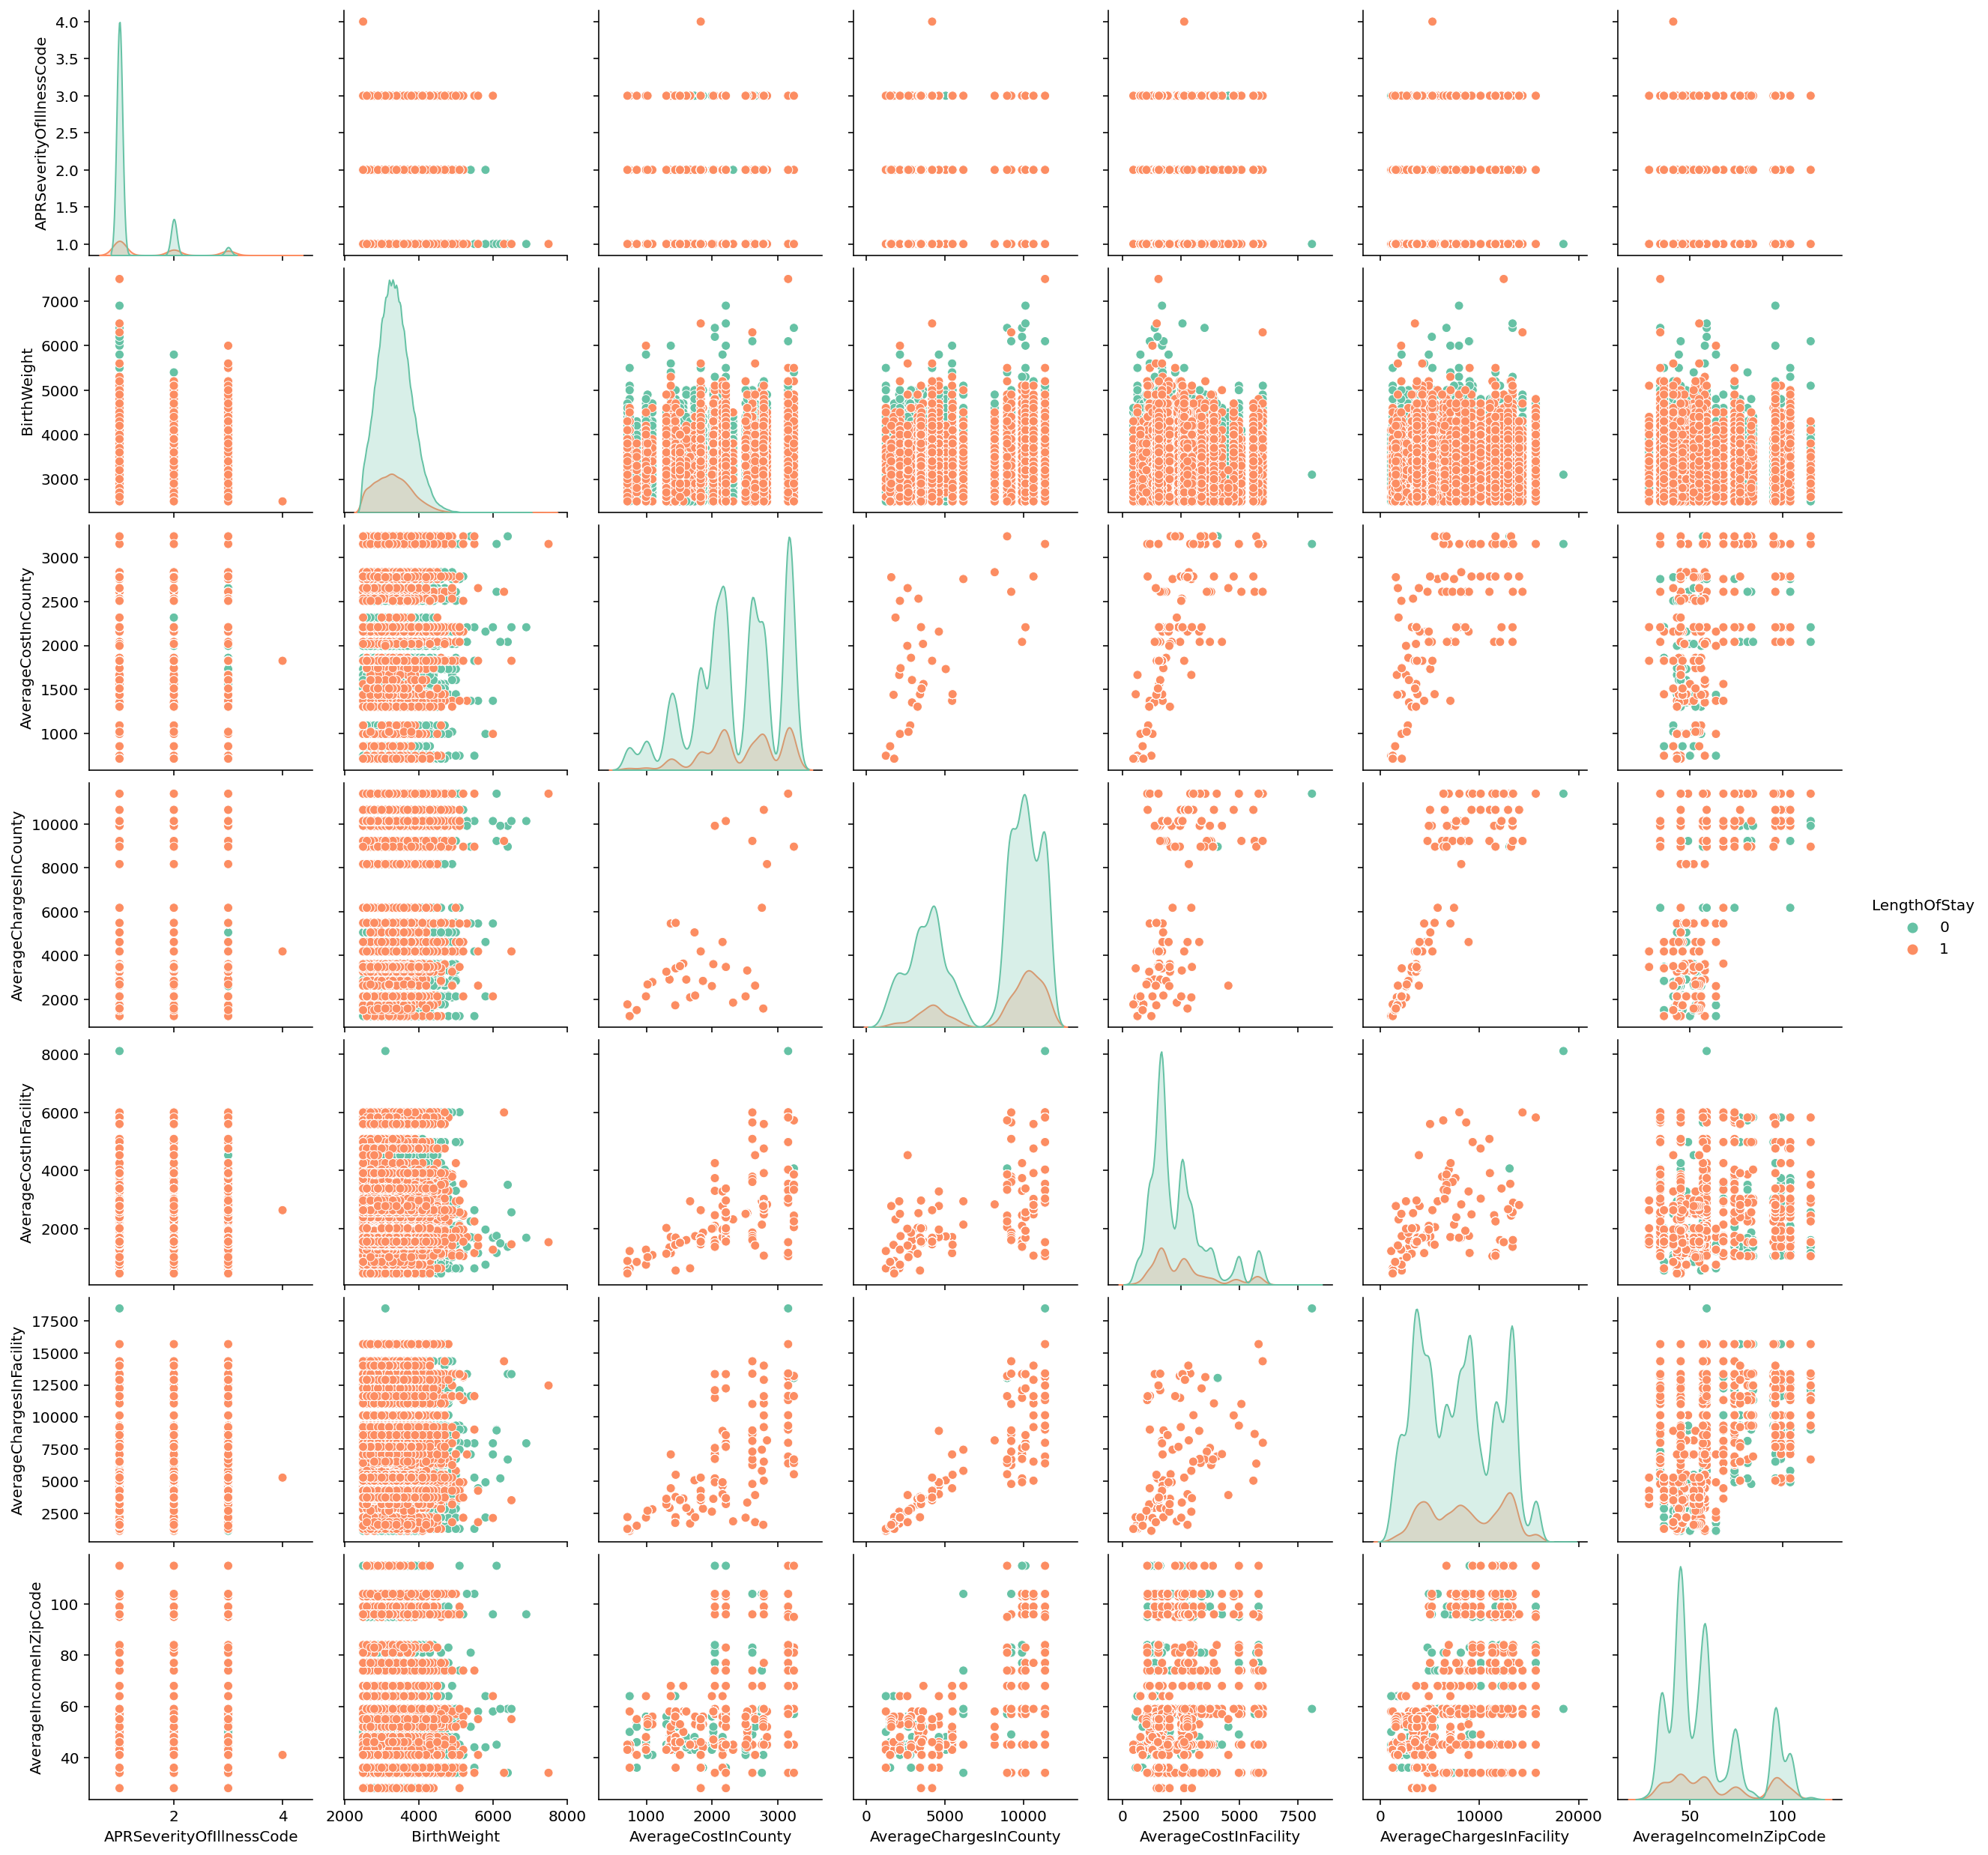

In [14]:
sns.pairplot(data, kind="scatter", hue="LengthOfStay", palette="Set2")
plt.show()

## Initial impressions from the correlogram
- It seems that the babies with higher birth weights have acute care because they are healthier. It is ususal for underweight babies to remain in care for a few extra days, so this makes sense.
- Rest of the columns do not show any clear patterns in the data.

# performance and evaluation metrics
- The goal of the analysis is to predict whether the length of stay will be greater than 3 days or otherwise.
- Since Average length of stay is often an indicator of customer satisfaction and hospital effciency. It is needed that a balance is struck between precision and accuracy of results, as the goal is to improve discharge planning.
- Since importance has to be given to both class 0 (acute care cases) as well as class 1 (longer care cases) but there is a clear case of class imbalance I will use 'macro_f1_score'
- As there is a clear case of class imbalance with 83% cases falling in class 0. I am targeting a model with over 60% f1 score.
- For the purpose of model training and evaluation, I will be using k-fold cross validation as the size of the data set is not huge.
- First I'll split the datset in training and testing sets then apply k-fold cross vaidation for model tuning and on training set then finally test the model on test set.

## Using Logistic Regression to set a baseline model performance
In the below model the folowing steps will be taken:
1. Create polynomial features
2. Create one hot encoder for categorical values
3. Create a quantile transformer for bringing the numerical values in a gaussian shape
4. Create a column transformer to embed all preprocessing steps.
5. Create training and test set
6. Create a grid of parameters to fit logistic model and apply regularization
7. Create a logistic classifier
8. Embed transformation steps and classifier in a Pipeline
9. Run randomized search for parameters of Logistic model pipeline
10. Check for over/underfitting on test set.

In [22]:
## Importing required libraries for building a logistic regression pipeline

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

## Create a copy of the original data
data_logit_models = data

## Create a list of c values for regularization
c_values = np.linspace(start = 0.001, stop = 0.3, num = 50)

## Create a column transformer to embed all transformation steps in one step
column_trans_logit_model = make_column_transformer(
    (PolynomialFeatures(3), num_col),
    (OneHotEncoder(handle_unknown='ignore'), cat_col),
    (QuantileTransformer(output_distribution='normal'), num_col),
    remainder = 'passthrough')

## Create training and testing set
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(data_logit_models, test_size=0.2, 
                                              shuffle=True,random_state=0)

## Printing the shape of training and test set
print("Number of training examples: ", train_data.shape[0])
print("Number of testing examples: ", test_data.shape[0])


## Splitting training set in features and label
train_X = train_data.drop('LengthOfStay', axis='columns')
train_y = train_data[['LengthOfStay']]

## Splitting test set set in features and label
test_X = test_data.drop('LengthOfStay', axis='columns')
test_y = test_data[['LengthOfStay']]

## Creating a parameters list for logistic regression
logit_param_grid = [{'model__penalty': ['l2'],
                     'model__C': c_values
                    }]

## Initializing a logistic classifier
logit_clf = LogisticRegression(class_weight='balanced', random_state=22, max_iter = 10000 )

## Building a pipeline, combining all steps
logit_pipeline = Pipeline( [('column_transformer',column_trans_logit_model),
                            ('model', logit_clf)
                           ])

## Creating a Randomized search CV instance using the pipeline and regularization parameters
logit_rand_search = RandomizedSearchCV(estimator = logit_pipeline, param_distributions = logit_param_grid,
                                       scoring='f1_macro')

## Fitting the rand search model
logit_rand_search_model = logit_rand_search.fit(train_X, train_y.values.ravel())

## Printing the results
print(logit_rand_search_model.best_params_)
print("The f1_macro score of the best model is: ", logit_rand_search_model.best_score_)

Number of training examples:  47972
Number of testing examples:  11994
{'model__penalty': 'l2', 'model__C': 0.2633877551020408}
The f1_macro score of the best model is:  0.5440238144804183


In [28]:
logit_rand_search_model.score(test_X, test_y)

0.5450730300708628

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred_logit = logit_rand_search_model.predict(test_X)
print(classification_report(test_y, y_pred_logit))

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      9943
           1       0.25      0.56      0.34      2051

    accuracy                           0.64     11994
   macro avg       0.56      0.60      0.55     11994
weighted avg       0.77      0.64      0.68     11994



### Observations:
- The logistic models best performance is around the 54% mark for macro F1 score. In further analysis, this will be the baseline model.
- The model still performs very poorly for the class 1

# Decision Tree and Random Forest
1. Splitting the data in training, validation and test sets.
2. Convert categorical values to suitable continuous format. Using onehot encoding because test_data has extra categories which onehot encoding can handle gracefully.

In [23]:
from sklearn.model_selection import GridSearchCV
# Step 1: Splitting the data in training, validation and test sets.
data_tree_based_models = data
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(data_tree_based_models, test_size=0.2, 
                                              shuffle=True,random_state=0)

print("Number of training examples: ", train_data.shape[0])
print("Number of testing examples: ", test_data.shape[0])

train_X = train_data.drop('LengthOfStay', axis='columns')
train_y = train_data[['LengthOfStay']]

test_X = test_data.drop('LengthOfStay', axis='columns')
test_y = test_data[['LengthOfStay']]

# Step 2: Convert categorical values to suitable continuous format

column_trans_tree_models = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_col),
    remainder = 'passthrough'
)

# Defining Decision tree model
from sklearn.tree import DecisionTreeClassifier

# Tree limiting parameters
param_grid = [{'model__max_depth': np.arange(2,200, 20),
               'model__min_samples_split': np.arange(20,200,20),
               'model__criterion': ['gini', 'entropy']
              }
             ]
dt_clf = DecisionTreeClassifier(class_weight='balanced')


DT_pipeline = Pipeline( [('ohe',column_trans_tree_models),
                         ('model', dt_clf)
                        ]
                      )

grid_search_manual_param = GridSearchCV(estimator=DT_pipeline, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, verbose = 10)
best_model = grid_search_manual_param.fit(train_X, train_y)

print(best_model.best_estimator_)
print("The f1_macro score of the best model is: ", best_model.best_score_)

Number of training examples:  47972
Number of testing examples:  11994
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Race',
                                                   'TypeOfAdmission',
                                                   'CCSProcedureCode',
                                                   'PaymentTypology',
                                                   'EmergencyDepartmentIndicator'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=22,
                                        min_samples_split=180))])
The f1_macro score of the

In [42]:
y_pred_DT_RS = best_model.predict(test_X)
print(classification_report(test_y, y_pred_DT_RS))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      9943
           1       0.33      0.67      0.44      2051

    accuracy                           0.71     11994
   macro avg       0.62      0.69      0.62     11994
weighted avg       0.81      0.71      0.74     11994



### Observation:
- The Decision trees show a significant improvement in the performance with an F1_macro score of 0.62%
- Also the predictor is not overfitted so that is a good sign.

In [25]:
path = DT_pipeline[-1].cost_complexity_pruning_path(DT_pipeline[:-1].fit_transform(train_X), train_y)

param_grid_post_pruning = [{'model__ccp_alpha': path.ccp_alphas[:-1]
                           }]

rand_search_post_pruning = RandomizedSearchCV(estimator=DT_pipeline, param_distributions=param_grid_post_pruning,
                                              scoring='f1_macro', n_jobs=-1, n_iter = 1000, verbose = 10, cv = 3)
best_model_post_pruning = rand_search_post_pruning.fit(train_X, train_y)

print(best_model_post_pruning.best_estimator_)
print("The f1_macro score of the best model is: ", best_model_post_pruning.best_score_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


C:\Users\shekh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.58256574 0.57788008 0.58848892 0.57817009 0.57741173 0.58268989
 0.58162366 0.58533426 0.58534022 0.58074747 0.58659758 0.580185
 0.57954001 0.57855621 0.58127843 0.58923393 0.58194063 0.57832891
 0.58111342 0.58024958 0.57702293 0.57745515 0.58076528 0.58249667
 0.58215779 0.57784013 0.57818715 0.58284421 0.57913256 0.58192726
 0.57893527 0.58893325 0.5832972  0.58808776 0.57831933 0.58890985
 0.5773538  0.57796076 0.57750414 0.58605085 0.58730282 0.57707967
 0.5841608  0.57873668 0.58549838 0.57704411 0.58427672 0.57784323
 0.57842383 0.58276643 0.57792794 0.57867681 0.58558801 0.58798693
 0.58226183 0.58260192 0.57861878 0.57817755 0.58808448 0.57659913
 0.57726775 0.58097368 0.58503157 0.58752596 0.57603986 0.58805097
 0.60146666 0.57867039 0.58591171 0.58588702 0.58111253 0.58093308
 0.57677521 0.58849381 0.58740693 0.58782679 0.58582313

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Race',
                                                   'TypeOfAdmission',
                                                   'CCSProcedureCode',
                                                   'PaymentTypology',
                                                   'EmergencyDepartmentIndicator'])])),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.00021375669548743398,
                                        class_weight='balanced'))])
The f1_macro score of the best model is:  0.6208033600811741


In [43]:
y_pred_DT_ccp = best_model_post_pruning.predict(test_X)
print(classification_report(test_y, y_pred_DT_ccp))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9943
           1       0.32      0.75      0.45      2051

    accuracy                           0.68     11994
   macro avg       0.62      0.71      0.61     11994
weighted avg       0.83      0.68      0.72     11994



## Observation
- The model tuned using CCP alpha is also very similar in terms of performance with a macro average of 61%.
- This model is also not overfitted.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

data_tree_based_models = data

column_trans_tree_models = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_col),
    remainder = 'passthrough'
)

with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(data_tree_based_models, test_size=0.2, 
                                              shuffle=True,random_state=0)

print("Number of training examples: ", train_data.shape[0])
print("Number of testing examples: ", test_data.shape[0])

train_X = train_data.drop('LengthOfStay', axis='columns')
train_y = train_data[['LengthOfStay']].to_numpy()

test_X = test_data.drop('LengthOfStay', axis='columns')
test_y = test_data[['LengthOfStay']].to_numpy()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 1200, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)

RF_param_grid = [{'model__max_depth': max_depth,
                  'model__n_estimators': n_estimators
                 }]

RF_clf = RandomForestClassifier(criterion = 'entropy', class_weight='balanced_subsample', n_jobs=-1)

RF_pipeline = Pipeline( [('ohe',column_trans_tree_models),
                         ('model', RF_clf)
                        ]
                      )

RF_grid_search = GridSearchCV(estimator=RF_pipeline, param_grid=RF_param_grid,
                              scoring='f1_macro', n_jobs=-1, verbose = 10,cv = 3)

RF_grid_search_model = RF_grid_search.fit(train_X, train_y)

print(RF_grid_search_model.best_estimator_)
print("The f1_macro score of the best model is: ", RF_grid_search_model.best_score_)

Number of training examples:  47972
Number of testing examples:  11994
Fitting 3 folds for each of 120 candidates, totalling 360 fits


C:\Users\shekh\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Race',
                                                   'TypeOfAdmission',
                                                   'CCSProcedureCode',
                                                   'PaymentTypology',
                                                   'EmergencyDepartmentIndicator'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=15,
                                        n_estimators=1022, n_jobs=-1))])
The f1_macro score of the best model is:  0.6480369931462646


In [44]:
y_pred_RF = RF_grid_search_model.predict(test_X)
print(classification_report(test_y, y_pred_RF))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      9943
           1       0.38      0.58      0.45      2051

    accuracy                           0.76     11994
   macro avg       0.64      0.69      0.65     11994
weighted avg       0.81      0.76      0.78     11994



In [67]:
## Predicting the test file
data_prediction = pd.read_csv('test_data.csv', index_col = 'ID', usecols = ['ID', 'Gender', 'Race', 'TypeOfAdmission', 'CCSProcedureCode',
                                                                  'APRSeverityOfIllnessCode', 'PaymentTypology', 'BirthWeight',
                                                                 'EmergencyDepartmentIndicator', 'AverageCostInCounty',
                                                                  'AverageChargesInCounty', 'AverageCostInFacility',
                                                                  'AverageChargesInFacility', 'AverageIncomeInZipCode'])

for column_name in cat_col:
    data_prediction[column_name] = data_prediction[column_name].astype('category')
    
test_predictions = RF_grid_search_model.predict(data_prediction)
prediction_dataframe = pd.DataFrame(test_predictions)
prediction_dataframe.index = prediction_dataframe.index+1
prediction_dataframe.rename(columns = {0:'LengthOfStay'}, inplace = True)
prediction_dataframe.to_csv('s3831855_predictions.csv')

## Conclusion
- Using the techniques taught in labs and lectures I have been able to get a best model using Random Forest classifier.
- The performance of best model is around 65% macro f1_score
- The model does a great job at predicting when a patient would be admitted for acute care buut performs poorly for the cases where patients will require longer care than 3 days.
- This could be because of class imbalance, but measures were taken while developing the model to get similar performances for both classes.
- For the class imbalance, maybe oversampling or undersampling would have helped.
- The final model is performing similarly on the test set as well, so I can say that it has fitted well.
- The predictions for the test data have been uploaded in *s3831855_predictions.csv*